## Using PyTorch to implement Softmax Regression to classify handwritten digit images.

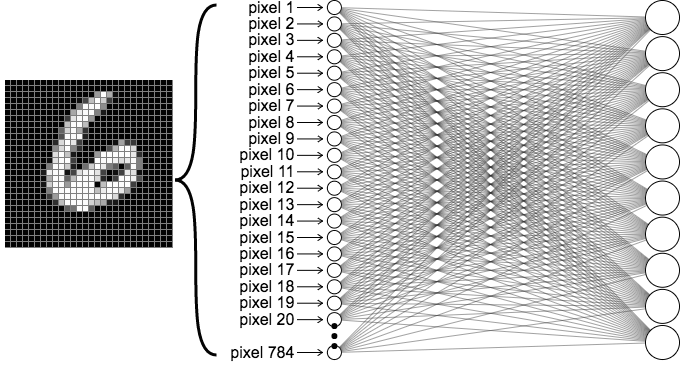

### A more complicated model

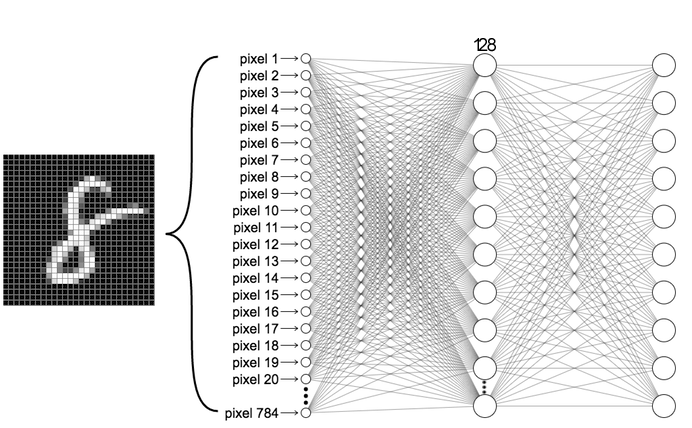

## Softmax Regression

In [ ]:
# Imports
import torch
import torch.nn as nn # contains common layers, operators
import torch.optim as optim # contains optimization algorithms
import torch.nn.functional as F # contains activation functions, e.g., sigmoid
from torch.utils.data import DataLoader # a library that helps us to handle big datasets that don't fit computer memory.
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Create a Softmax Regression Model
class SoftmaxRegression(nn.Module):
    def __init__(self, input_size, num_classes):  # digits 0, 1, 2, ..., 9
        super(SoftmaxRegression, self).__init__() # Python syntax
        self.layer = nn.Linear(in_features=input_size, out_features=num_classes)
    
    def forward(self, x):
        out = self.layer(x)
        #out = torch.sigmoid(out)  # We need to have this sigmoid here for Logistic Regression
        #out = torch.softmax(out)  # This is tricky. For Softmax Regression, we don't need to add softmax here.
        return out

In [ ]:
# Hyperparameters
input_size = 784 # 28x28 image
num_classes = 10 # 10 digits 0, 1, 2, ...., 9
learning_rate = 0.001
batch_size = 64 # We would devide our dataset into smaller batches. Each batch contains 64 images.
num_epochs = 5

In [ ]:
# Create the model
model = SoftmaxRegression(input_size=input_size, num_classes=num_classes).to(device)  #.to(device) puts our model on the GPU if available

In [ ]:
# Define the loss and the optimization algorithms
criterion = nn.CrossEntropyLoss()  # In PyTorch, Softmax + NLL
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset to our Google Drive
train_dataset = datasets.MNIST(root='/content/drive/MyDrive/datasets/mnist', train=True,
                               transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='/content/drive/MyDrive/datasets/mnist', train=False,
                               transform=transforms.ToTensor(), download=True)

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt

8


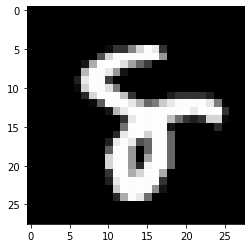

In [ ]:
image, label = train_dataset[312]
plt.imshow(image.squeeze(), cmap='gray')
print(label)

In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
# Train our Softmax Regression model
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Put the batch to GPU if available
        data = data.to(device) # Put images to the GPU if GPU is available
        targets = targets.to(device) # Put labels to the GPU if available

        # Our (batch) data here is in the form (batch_size, color_channel, width, height) ???
        # We need to change it to (batch_size, w*h)
        # (64, 1, 28, 28) ----> (64, 784)
        data = data.reshape(data.shape[0], -1) # data.shape[0] ~ batch_size

        # forward pass
        scores = model(data)  # Pass one batch of training examples through our model.
        loss = criterion(scores, targets) # Compute the loss function value J for this batch

        # backward pass
        optimizer.zero_grad()  # Empty the memory
        loss.backward()  # Compute the gradient dJ/dw
        optimizer.step()  # One step of gradient descent

        # Track the loss function values.
        if (batch_idx+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}, Loss {loss.item():.2f}')

Epoch 1/5, Batch 100, Loss 0.84
Epoch 1/5, Batch 200, Loss 0.59
Epoch 1/5, Batch 300, Loss 0.38
Epoch 1/5, Batch 400, Loss 0.33
Epoch 1/5, Batch 500, Loss 0.46
Epoch 1/5, Batch 600, Loss 0.46
Epoch 1/5, Batch 700, Loss 0.51
Epoch 1/5, Batch 800, Loss 0.38
Epoch 1/5, Batch 900, Loss 0.41
Epoch 2/5, Batch 100, Loss 0.31
Epoch 2/5, Batch 200, Loss 0.35
Epoch 2/5, Batch 300, Loss 0.32
Epoch 2/5, Batch 400, Loss 0.25
Epoch 2/5, Batch 500, Loss 0.37
Epoch 2/5, Batch 600, Loss 0.22
Epoch 2/5, Batch 700, Loss 0.29
Epoch 2/5, Batch 800, Loss 0.37
Epoch 2/5, Batch 900, Loss 0.30
Epoch 3/5, Batch 100, Loss 0.21
Epoch 3/5, Batch 200, Loss 0.81
Epoch 3/5, Batch 300, Loss 0.28
Epoch 3/5, Batch 400, Loss 0.22
Epoch 3/5, Batch 500, Loss 0.47
Epoch 3/5, Batch 600, Loss 0.47
Epoch 3/5, Batch 700, Loss 0.26
Epoch 3/5, Batch 800, Loss 0.19
Epoch 3/5, Batch 900, Loss 0.21
Epoch 4/5, Batch 100, Loss 0.21
Epoch 4/5, Batch 200, Loss 0.23
Epoch 4/5, Batch 300, Loss 0.31
Epoch 4/5, Batch 400, Loss 0.49
Epoch 4/

In [ ]:
# Evaluate the accuracy of the trained model
def check_accuracy(loader, model):
    num_corrects = 0
    num_samples = 0

    model.eval() # Put our model into evaluation mode
    with torch.no_grad():  # no need to compute the gradient here
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device)
            data = data.reshape(data.shape[0], -1) 

            # forward
            scores = model(data)  # Scores of a batch ---> in the form of (64, 10)
            #image 1: [s1, s2, s3, ...., s10]  ---> s2, 2
            #image 2: [s1, s2, s3, ...., s10]  ---> s10, 10
            #.....
            #image 64:[s1, s2, s3, ...., s10] ---> s7, 7
            _, preds = scores.max(1)
            
            num_corrects += (preds == targets).sum()
            num_samples += preds.size(0)

        print(f'We get {num_corrects}/{num_samples} correct. Accuracy = {float(num_corrects)/float(num_samples)*100.0:.2f}')

In [ ]:
check_accuracy(test_loader, model)

We get 9233/10000 correct. Accuracy = 92.33


1


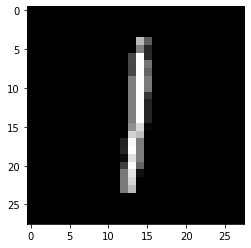

In [ ]:
# Check our trained model on a few examples
image, label = test_dataset[176]
plt.imshow(image.squeeze(), cmap='gray')
print(label)

In [ ]:
image = image.to(device) # Put the image to the GPU if available
image = image.reshape(image.shape[0], -1) # Reshape the tensor

score = model(image)
print(score)
_, preds = score.max(1)
print(f'Our prediction is {preds.item()}')

tensor([[-5.6872,  5.3777, -0.2378,  0.0919, -5.2969, -0.4733, -1.0080, -1.6983,
          0.4223, -1.0987]], device='cuda:0', grad_fn=<AddmmBackward>)
Our prediction is 1


In [ ]:
torch.nn.functional.softmax(score, dim=1)

tensor([[1.5304e-05, 9.7777e-01, 3.5601e-03, 4.9504e-03, 2.2612e-05, 2.8132e-03,
         1.6480e-03, 8.2637e-04, 6.8888e-03, 1.5051e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

8


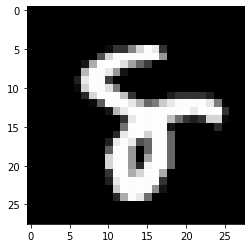

In [ ]:
# Check our trained model on a few examples
image, label = train_dataset[312]
plt.imshow(image.squeeze(), cmap='gray')
print(label)

In [ ]:
image = image.to(device) # Put the image to the GPU if available
image = image.reshape(image.shape[0], -1) # Reshape the tensor

score = model(image)
print(score)
_, preds = score.max(1)
print(f'Our prediction is {preds.item()}')

tensor([[ -8.4080, -11.1029,  -3.2151,  -7.4497,  -1.6929,  -5.1792,   1.7999,
          -7.3451,   5.9408,  -2.6805]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Our prediction is 8


In [ ]:
score.max(1)

torch.return_types.max(values=tensor([5.9408], device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([8], device='cuda:0'))

In [ ]:
model

SoftmaxRegression(
  (layer): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
# Print the model
model.state_dict()

OrderedDict([('layer.weight',
              tensor([[-0.0172,  0.0279,  0.0265,  ...,  0.0302, -0.0129, -0.0274],
                      [-0.0067, -0.0044, -0.0213,  ...,  0.0065,  0.0286, -0.0351],
                      [ 0.0116, -0.0193,  0.0220,  ..., -0.0029, -0.0204, -0.0163],
                      ...,
                      [ 0.0066, -0.0262,  0.0209,  ..., -0.0329, -0.0119,  0.0243],
                      [ 0.0260,  0.0250,  0.0063,  ...,  0.0265, -0.0208,  0.0046],
                      [ 0.0287,  0.0293, -0.0188,  ...,  0.0006,  0.0195,  0.0323]],
                     device='cuda:0')),
             ('layer.bias',
              tensor([-0.3162,  0.4009,  0.0165, -0.2590,  0.1180,  0.7055, -0.0557,  0.3885,
                      -0.8357, -0.1534], device='cuda:0'))])

### Look closely at the weight values

Getting the weights corresponding to the output neuron associated with digit **0**.

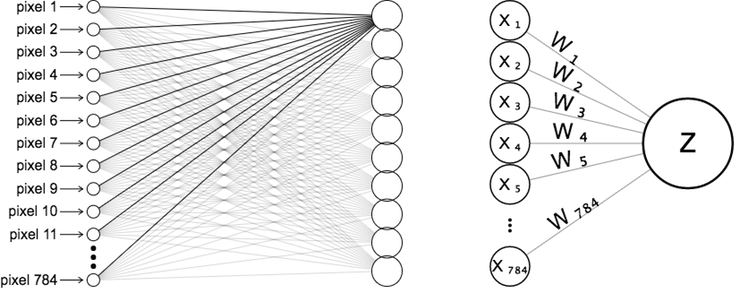


Transform the weight vector into $(28\times 28)$ matrix.

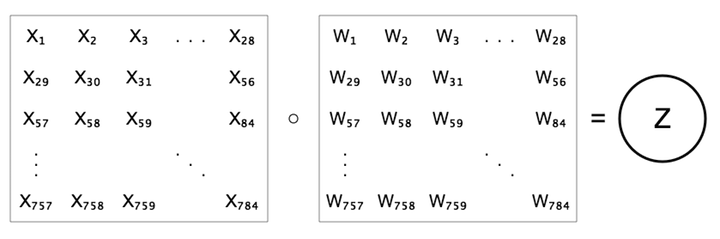

In [ ]:
weight_digit_0 = model.state_dict()['layer.weight'][3]
print(weight_digit_0.shape)

torch.Size([784])


Transform the weight vector in a $(28\times 28)$ matrix.

In [ ]:
weight_matrix = weight_digit_0.reshape(28, 28).cpu().numpy()
print(weight_matrix.shape)

(28, 28)


Visualize the weight matrix.

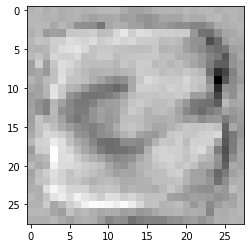

In [ ]:
plt.imshow(weight_matrix, cmap='gray')